We first start by importing the required packages.

In [1]:
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import Label
from urllib.request import urlopen
from urllib.error import HTTPError
import pickle
import requests
import datetime as dt
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.corpus import wordnet
import numpy as np
import gzip
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sb
import pyLDAvis.sklearn

# Reading in data

In this version of LDA, to visual the data how we would like we needed to switch packages from Gensim to sklearn's LatentDirichletAllocation package. This meant we have to do some preprocess of the data now instead of simply loading the pickle files as before. Hence we read in our data from Github and perform regex to remove punctuation, symbols, etc in our data so we can tokenise our data and effectively make our corpus again. We then aimed to before some dimensionality reduction to see how this would effect our results.

In [2]:
df = pd.read_csv("https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/master_log_10.csv.gz")
data_text=df[['log']]
data_text['index']=data_text.index
print(data_text[:5])
print(len(data_text))

                                                 log  index
0  Jan  5 03:23:54 161.166.1.23 sshd[27076]: Fail...      0
1  Jan  5 03:24:25 161.166.1.23 sshd[27087]: Disc...      1
2  Jan  5 03:24:27 161.166.1.23 sshd[27090]: pam_...      2
3  Jan  5 04:08:19 161.166.1.23 sshd[27584]: PAM ...      3
4  Jan  5 04:08:21 161.166.1.23 sshd[27590]: pam_...      4
1588052


# Regex

In [3]:
import re
def regex(text):
    text = re.sub(r"[0-9]+\.[0-9]+\.[0-9]+\.[0-9]+"," ",text) #Filters out ip adresses
    text = re.sub(r"[0-9]{2}\:[0-9]{2}\:[0-9]{2}"," ",text)#filters out times
    text = re.sub(r'\d+'," ",text) #filters out numbers
    text = re.sub(r"[^A-Za-z0-9 ]+"," ",text) # filters out punctuation
    text = re.sub(r"XXXXX"," ",text) #filters out anonymised user
    text = re.sub(r"HHHHH"," ",text)
    text = re.sub(r"sshd"," ",text) #sshd comes up in every log and is not required
    text = re.sub(r"ruser","user",text)
    text = re.sub(r"rhost","host",text)
    text = re.sub(r"euid","user",text)
    text = text.lower()
    return text

In [4]:
doc = data_text['log']
doc.head()

0    Jan  5 03:23:54 161.166.1.23 sshd[27076]: Fail...
1    Jan  5 03:24:25 161.166.1.23 sshd[27087]: Disc...
2    Jan  5 03:24:27 161.166.1.23 sshd[27090]: pam_...
3    Jan  5 04:08:19 161.166.1.23 sshd[27584]: PAM ...
4    Jan  5 04:08:21 161.166.1.23 sshd[27590]: pam_...
Name: log, dtype: object

In [5]:
process = doc.map(regex)

In [6]:
process.head()

0    jan             failed password for   from   p...
1    jan             disconnecting  too many authen...
2    jan             pam unix   auth  authenticatio...
3    jan             pam service    ignoring max re...
4    jan             pam unix   auth  authenticatio...
Name: log, dtype: object

We use CountVectorizer to count the number of times a word occurs in our corpus. We then want to learn the dictionary and return a document-term matrix.

In [7]:
data_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)
data_document_term_matrix = data_count_vectorizer.fit_transform(process)
n_topics=10

We know have all we know to train our LDA model again using the sklearn LDA package this time and then fit this to a topic matrix.

In [10]:
try:
    print("Attempting to read model from pickle")
    fp=gzip.open(urlopen('https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/main/lda_model2.pkl.gz'),'rb')
    lda_model2=pickle.load(fp)
    fp.close()
    print("Model read from pickle.")
except HTTPError as err:
    if err.code == 404:
        print("Pickle not found, creating model and saving to pickle")
        start=dt.datetime.now()
        lda_model2 = LatentDirichletAllocation(n_components=n_topics, learning_method='online', random_state=0,verbose=0)
        fp=gzip.open('G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/DST-Assessment-03/data/main/lda_model2.pkl.gz','wb')
        pickle.dump(lda_model2,fp)
        fp.close()
        print("Pickle saved. Time taken: " + str(dt.datetime.now()-start))
    else:
        raise

Attempting to read model from pickle
Pickle not found, creating model and saving to pickle
Pickle saved. Time taken: 0:00:00.001003


In [11]:
try:
    print("Attempting to read topic matrix from pickle")
    fp=gzip.open(urlopen('https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/main/lda_topic_matrix.pkl.gz'),'rb')
    lda_topic_matrix=pickle.load(fp)
    fp.close()
    print("Topic matrix read from pickle.")
except HTTPError as err:
    if err.code == 404:
        print("Pickle not found, creating topic matrix and saving to pickle")
        start=dt.datetime.now()
        lda_topic_matrix = lda_model2.fit_transform(data_document_term_matrix)
        fp=gzip.open('G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/DST-Assessment-03/data/main/lda_topic_matrix.pkl.gz','wb')
        pickle.dump(lda_topic_matrix,fp)
        fp.close()
        print("Pickle saved. Time taken: " + str(dt.datetime.now()-start))
    else:
        raise

Attempting to read topic matrix from pickle
Pickle not found, creating topic matrix and saving to pickle
Pickle saved. Time taken: 0:40:27.025222


In [12]:
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

Here we decided to do some dimensionality reduction use t-Distributed Stochastic Neighbour Embedding (t-SNE) which minimises the divergence between two distributions. t-SNE maps the multi-dimensional data to a lower dimensional space and analyses any observed clusters based off the similarity of data points which feature multiple times. After this however, no inferences can be made as the input features cannot be identified anymore, hence why we are using it to mainly to try and visualise our data, allowing us to hopefully some conclusions. 

In [13]:
%%capture
try:
    print("Attempting to read tsne model from pickle")
    fp=gzip.open(urlopen('https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/main/tsne_model.pkl.gz'),'rb')
    tsne_lda_model2=pickle.load(fp)
    fp.close()
    print("Model read from pickle.")
except HTTPError as err:
    if err.code == 404:
        print("Pickle not found, creating tsne model and saving to pickle")
        start=dt.datetime.now()
        tsne_lda_model2 = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
        fp=gzip.open('G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/DST-Assessment-03/data/main/tsne_model.pkl.gz','wb')
        pickle.dump(tsne_lda_model2,fp)
        fp.close()
        print("Pickle saved. Time taken: " + str(dt.datetime.now()-start))
    else:
        raise

In [14]:
%%capture
try:
    print("Attempting to read tsne vectors from pickle")
    fp=gzip.open(urlopen('https://github.com/Galeforse/DST-Assessment-03/raw/master/Data/main/tsne_lda_vectors.pkl.gz'),'rb')
    tsne_lda_vectors=pickle.load(fp)
    fp.close()
    print("Model read from pickle.")
except HTTPError as err:
    if err.code == 404:
        print("Pickle not found, creating tsne vectors and saving to pickle")
        start=dt.datetime.now()
        tsne_lda_vectors = tsne_lda_model2.fit_transform(lda_topic_matrix)
        fp=gzip.open('G:/Users/Gabriel/Documents/Education/UoB/GitHubDesktop/DST-Assessment-03/data/main/tsne_lda_vectors.pkl.gz','wb')
        pickle.dump(tsne_lda_vectors,fp)
        fp.close()
        print("Pickle saved. Time taken: " + str(dt.datetime.now()-start))
    else:
        raise

In [15]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])


In [22]:
show(plot)

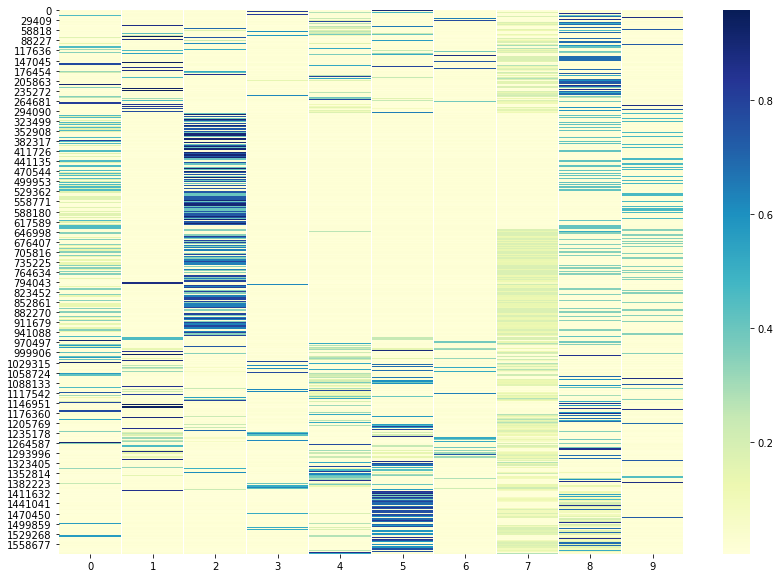

In [16]:
fig, ax = plt.subplots(figsize=(14,10))
sb.heatmap(lda_topic_matrix, cmap="YlGnBu", ax=ax);
plt.show()

## Luke the below part isn't goint to work due to the nature of the data and method and tbh I don't think it's worth even trying to run given the terribleness of the clustering. We can just draw conclusions from that and talk about how it failed but we tried xD

In [14]:
dictionary = gensim.corpora.Dictionary(processed)


log_perplexitites = {'lda_model2': lda_model2.perplexity(corpus),
                     'tsne_lda_model2': tsne_lda_vectors.perplexity(corpus)}

log_perplexitites 


ValueError: Expected 2D array, got 1D array instead:
array=[list([(0, 1), (1, 1), (2, 1)]) list([(3, 1), (4, 1), (5, 1), (6, 1)])
 list([(4, 1), (5, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)])
 ... list([(96, 1), (129, 1), (227, 1), (281, 1)])
 list([(13, 1), (23, 1)]) list([(13, 1), (23, 1)])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.